<a href="https://colab.research.google.com/github/alligmckernan/ADS-505-Final-Project/blob/main/ADS_505_Team_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# =====================================================
# ADS-505 Final Project — Miscarriage Prediction
# =====================================================

# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# Import CalibrationDisplay after upgrading scikit-learn
from sklearn.calibration import CalibrationDisplay


import warnings
warnings.filterwarnings("ignore")

# Random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Define the path to the dataset
# The file is located directly in the /content directory, not in Google Drive.
file_path = '/content/Miscarriage_Prediction_dataset_New_HA.csv'
# Load the dataset

# Changed the delimiter to semicolon
df = pd.read_csv(file_path, delimiter=';')
print("Shape:", df.shape)

# Convert 'BMI' column to numeric after replacing commas with periods
df['BMI'] = df['BMI'].str.replace(',', '.', regex=False).astype(float)

# Display the first few rows and the columns and their data types
display(df.head())
display(df.info())

Shape: (1000000, 16)


,Age,BMI,Nmisc,Activity,Binking,Walking,Drinving,Sitting,Location,temp,bpm,stress,bp,Alcohol Comsumption,Drunk,Miscarriage/ No Miscarriage
0,22,16.688239,0,1,0,0,1,1,2,38,103,0,2,449,0,0
1,22,16.688239,0,1,0,0,1,1,1,36,103,0,2,276,2,0
2,22,16.688239,2,1,0,0,1,1,3,38,103,0,2,534,2,0
3,22,16.688239,0,1,0,1,0,1,2,39,102,1,2,230,2,0
4,22,16.688239,1,1,0,1,0,1,3,35,102,1,2,364,2,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 16 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   Age                          1000000 non-null  int64  
 1   BMI                          1000000 non-null  float64
 2   Nmisc                        1000000 non-null  int64  
 3   Activity                     1000000 non-null  int64  
 4   Binking                      1000000 non-null  int64  
 5   Walking                      1000000 non-null  int64  
 6   Drinving                     1000000 non-null  int64  
 7   Sitting                      1000000 non-null  int64  
 8   Location                     1000000 non-null  int64  
 9   temp                         1000000 non-null  int64  
 10  bpm                          1000000 non-null  int64  
 11  stress                       1000000 non-null  int64  
 12  bp                           1000000 non-nu

None

In [3]:
# =====================================================
# Data overview
# =====================================================
print(df.info())
print(df.describe(include='all').T)

# Missing values
missing = df.isna().mean().sort_values(ascending=False)
print("\nMissing values (top 10):")
print(missing.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 16 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   Age                          1000000 non-null  int64  
 1   BMI                          1000000 non-null  float64
 2   Nmisc                        1000000 non-null  int64  
 3   Activity                     1000000 non-null  int64  
 4   Binking                      1000000 non-null  int64  
 5   Walking                      1000000 non-null  int64  
 6   Drinving                     1000000 non-null  int64  
 7   Sitting                      1000000 non-null  int64  
 8   Location                     1000000 non-null  int64  
 9   temp                         1000000 non-null  int64  
 10  bpm                          1000000 non-null  int64  
 11  stress                       1000000 non-null  int64  
 12  bp                           1000000 non-nu


Data structure:
(1000000, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 16 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   Age                          1000000 non-null  int64  
 1   BMI                          1000000 non-null  float64
 2   Nmisc                        1000000 non-null  int64  
 3   Activity                     1000000 non-null  int64  
 4   Binking                      1000000 non-null  int64  
 5   Walking                      1000000 non-null  int64  
 6   Drinving                     1000000 non-null  int64  
 7   Sitting                      1000000 non-null  int64  
 8   Location                     1000000 non-null  int64  
 9   temp                         1000000 non-null  int64  
 10  bpm                          1000000 non-null  int64  
 11  stress                       1000000 non-null  int64  
 12  bp          

,count,mean,std,min,25%,50%,75%,max
Age,1000000.0,28.002910,3.742043,22.000000,25.000000,28.000000,31.000000,34.000000
BMI,1000000.0,21.606415,2.961841,16.688239,18.827757,21.395178,24.390503,26.530021
Nmisc,1000000.0,1.500901,1.117784,0.000000,1.000000,2.000000,3.000000,3.000000
Activity,1000000.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Binking,1000000.0,0.499314,0.500000,0.000000,0.000000,0.000000,1.000000,1.000000
Walking,1000000.0,0.498280,0.499997,0.000000,0.000000,0.000000,1.000000,1.000000
Drinving,1000000.0,0.002406,0.048992,0.000000,0.000000,0.000000,0.000000,1.000000
Sitting,1000000.0,0.500419,0.500000,0.000000,0.000000,1.000000,1.000000,1.000000
Location,1000000.0,2.001708,1.413462,0.000000,1.000000,2.000000,3.000000,4.000000
temp,1000000.0,37.783945,1.819482,35.000000,36.000000,38.000000,39.000000,41.000000



Correlation of numeric variables with target:
Miscarriage/ No Miscarriage    1.000000
Age                            0.247124
Drinving                       0.002587
BMI                            0.002023
stress                         0.000873
Walking                        0.000610
Drunk                          0.000516
Location                       0.000184
Sitting                       -0.000015
Nmisc                         -0.000255
Name: Miscarriage/ No Miscarriage, dtype: float64

Top correlated predictors: ['Age', 'Drinving', 'BMI', 'stress', 'Walking', 'Drunk', 'Location', 'Sitting']


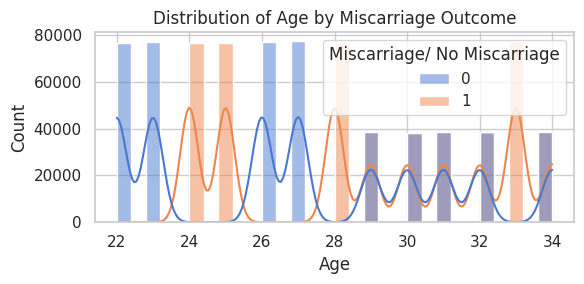

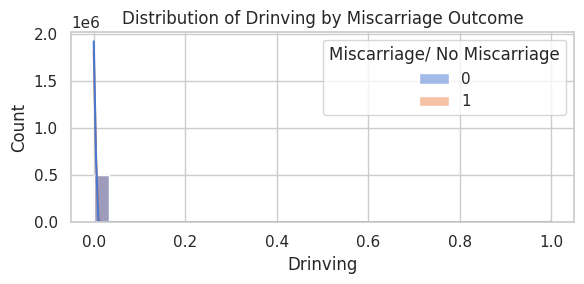

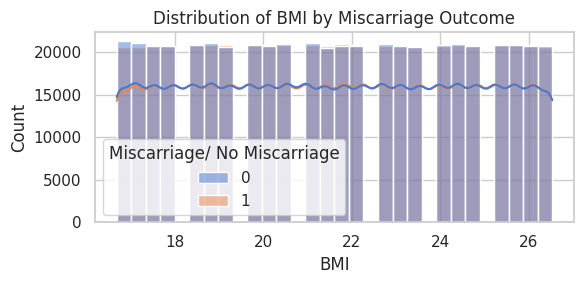

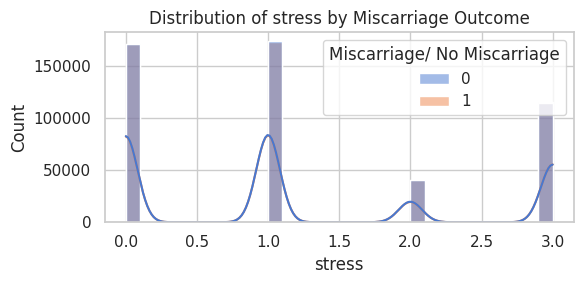

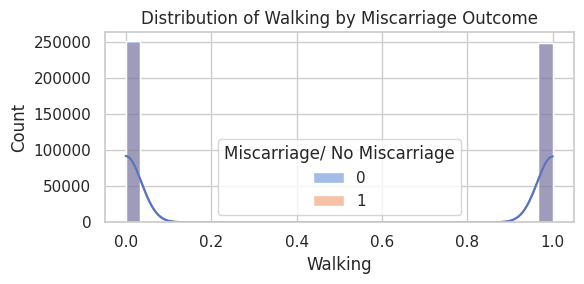

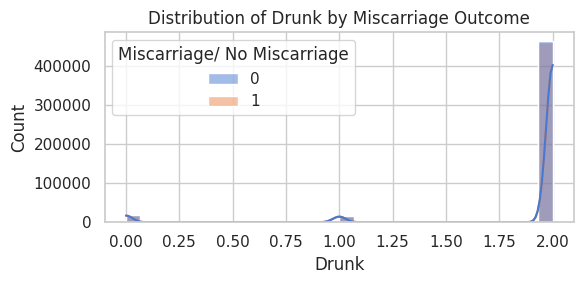

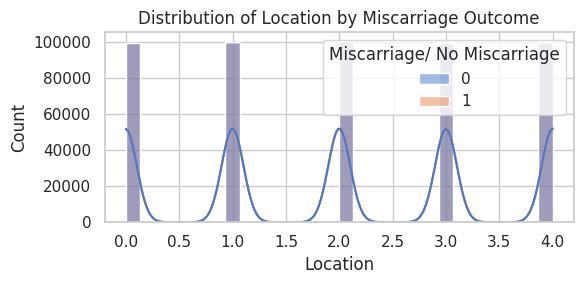

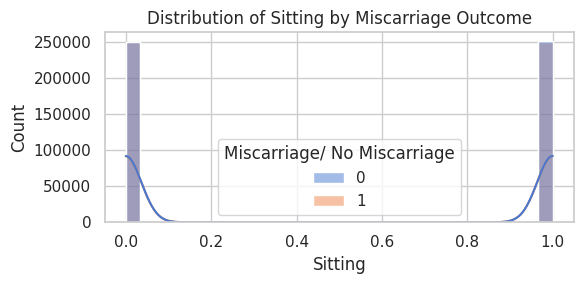

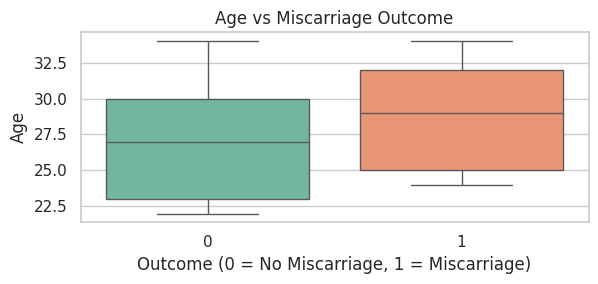

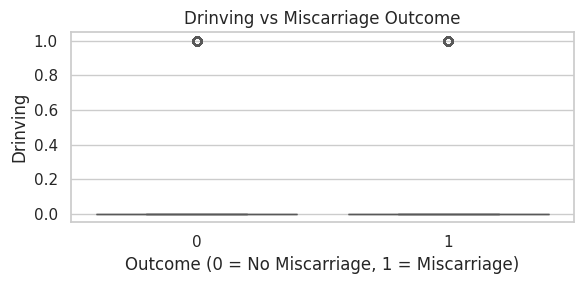

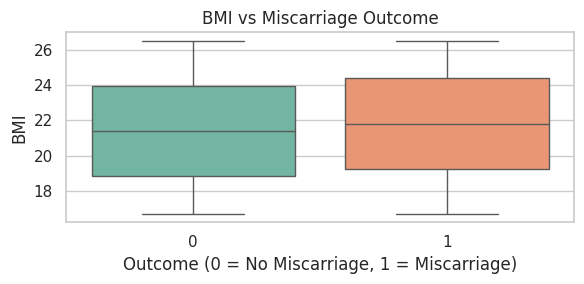

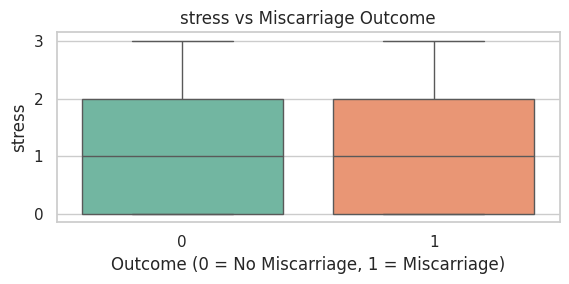

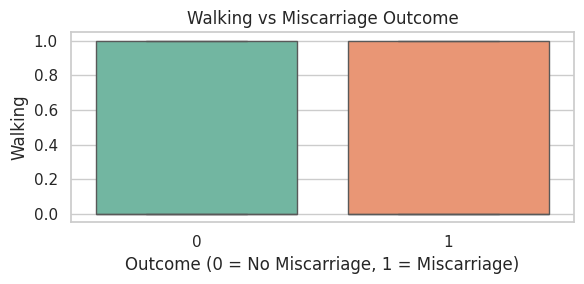

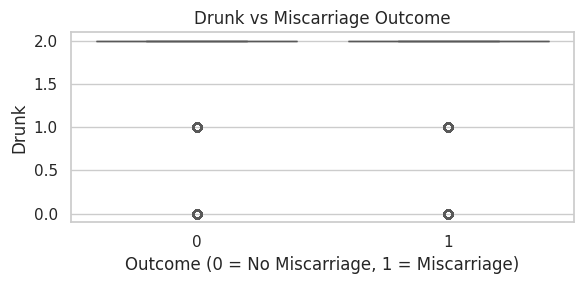

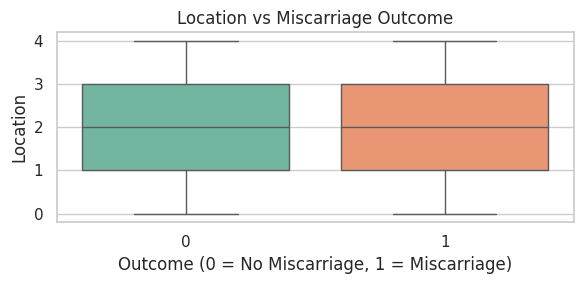

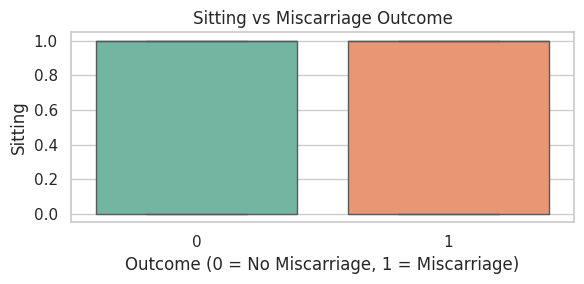


Mann–Whitney U Tests for Group Differences
---------------------------------------------------
Age                   U = 89449496386.5  p = 0.0000  → Significant
Drinving              U = 124968150066.5  p = 0.0097  → Significant
BMI                   U = 124708051684.5  p = 0.0430  → Significant
stress                U = 124902339269.5  p = 0.4778  → ns
Walking               U = 124923578039.5  p = 0.5418  → ns
Drunk                 U = 124981377821.0  p = 0.7758  → ns
Location              U = 124973722525.5  p = 0.8535  → ns
Sitting               U = 125001717355.0  p = 0.9880  → ns


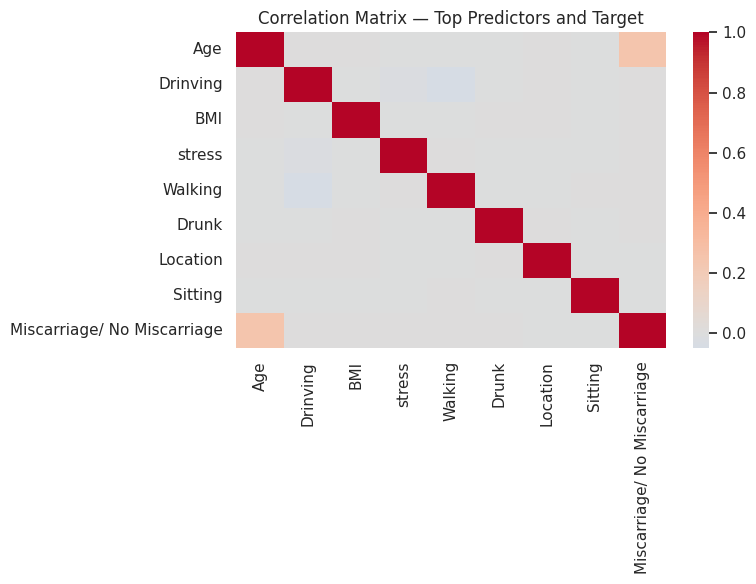

In [4]:
# =====================================================
# Exploratory Data Analysis (per Shmueli et al., 2020 Ch. 3)
# =====================================================
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import mannwhitneyu

sns.set(style="whitegrid")

TARGET_COL = 'Miscarriage/ No Miscarriage'

# --- 1. Basic structure and summary ---
print("\nData structure:")
print(df.shape)
print(df.info())
print("\nSummary statistics:")
display(df.describe(include='all').T)

# --- 2. Correlation analysis (numeric variables only) ---
corr_matrix = df.corr(numeric_only=True)
corr_with_target = corr_matrix[TARGET_COL].sort_values(ascending=False)
print("\nCorrelation of numeric variables with target:")
print(corr_with_target.head(10))

# --- 3. Select top correlated predictors (top 8 excluding target) ---
top_corrs = corr_with_target.index[1:9]
print("\nTop correlated predictors:", list(top_corrs))

# --- 4. Histograms (Lab 1 style visual check) ---
for col in top_corrs:
    plt.figure(figsize=(6,3))
    sns.histplot(df, x=col, hue=TARGET_COL, bins=30, kde=True, palette='muted')
    plt.title(f"Distribution of {col} by Miscarriage Outcome")
    plt.xlabel(col); plt.ylabel("Count")
    plt.tight_layout(); plt.show()

# --- 5. Boxplots for group comparison (Shmueli et al. §3.4) ---
for col in top_corrs:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=TARGET_COL, y=col, data=df, palette='Set2')
    plt.title(f"{col} vs Miscarriage Outcome")
    plt.xlabel("Outcome (0 = No Miscarriage, 1 = Miscarriage)")
    plt.ylabel(col)
    plt.tight_layout(); plt.show()

# --- 6. Non-parametric test for mean/median differences (as in Labs) ---
print("\nMann–Whitney U Tests for Group Differences")
print("---------------------------------------------------")
for col in top_corrs:
    group0 = df.loc[df[TARGET_COL]==0, col].dropna()
    group1 = df.loc[df[TARGET_COL]==1, col].dropna()
    stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
    signif = "Significant" if p < 0.05 else "ns"
    print(f"{col:<20}  U = {stat:>10.1f}  p = {p:>.4f}  → {signif}")

# --- 7. Correlation heatmap (Lab visualization) ---
plt.figure(figsize=(8,6))
sns.heatmap(df[top_corrs.tolist() + [TARGET_COL]].corr(), cmap='coolwarm', center=0, annot=False)
plt.title("Correlation Matrix — Top Predictors and Target")
plt.tight_layout(); plt.show()


In [5]:
# =====================================================
# DATA PREPROCESSING — Train/Test Split Only
# =====================================================

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Define target column
TARGET_COL = 'Miscarriage/ No Miscarriage'  # <-- change to actual target name
if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found. Available: {df.columns.tolist()}")

# Separate features (X) and target (y)
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(int)

# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]
print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# Train/Test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Pipelines for preprocessing
numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing
preprocess = ColumnTransformer([
    ('num', numeric_pipe, num_cols),
    ('cat', categorical_pipe, cat_cols)
])

# Fit the preprocessor on train data only
preprocess.fit(X_train)

# Transform both sets
X_train_prepared = preprocess.transform(X_train)
X_test_prepared = preprocess.transform(X_test)

print("Preprocessing complete.")
print("Transformed train shape:", X_train_prepared.shape)
print("Transformed test shape:", X_test_prepared.shape)


Numeric columns: ['Age', 'BMI', 'Nmisc', 'Activity', 'Binking', 'Walking', 'Drinving', 'Sitting', 'Location', 'temp', 'bpm', 'stress', 'bp', 'Alcohol Comsumption', 'Drunk']
Categorical columns: []
Train shape: (800000, 15)
Test shape: (200000, 15)
Preprocessing complete.
Transformed train shape: (800000, 15)
Transformed test shape: (200000, 15)



=== Logistic Regression — Test Set ===
ROC-AUC: 0.6432
Confusion Matrix:
 [[61810 38304]
 [40701 59185]]
              precision    recall  f1-score   support

           0     0.6030    0.6174    0.6101    100114
           1     0.6071    0.5925    0.5997     99886

    accuracy                         0.6050    200000
   macro avg     0.6050    0.6050    0.6049    200000
weighted avg     0.6050    0.6050    0.6049    200000



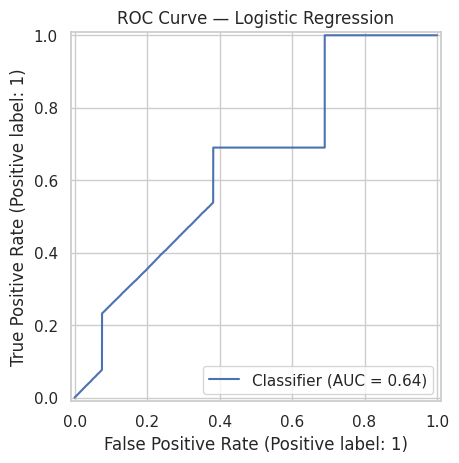

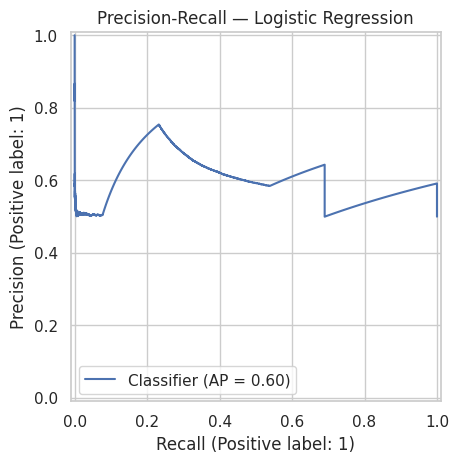

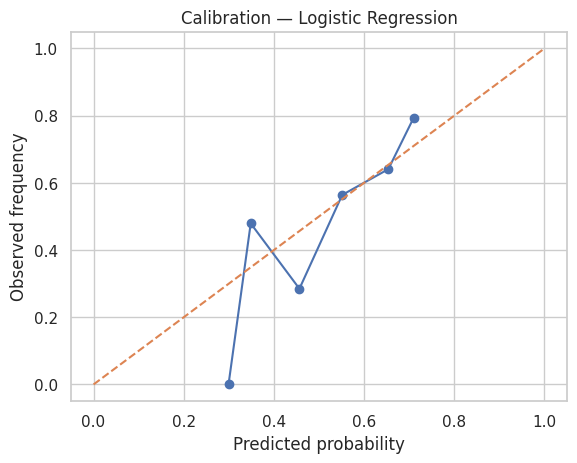


=== Random Forest — Test Set ===
ROC-AUC: 0.9255
Confusion Matrix:
 [[74121 25993]
 [12284 87602]]
              precision    recall  f1-score   support

           0     0.8578    0.7404    0.7948    100114
           1     0.7712    0.8770    0.8207     99886

    accuracy                         0.8086    200000
   macro avg     0.8145    0.8087    0.8077    200000
weighted avg     0.8146    0.8086    0.8077    200000



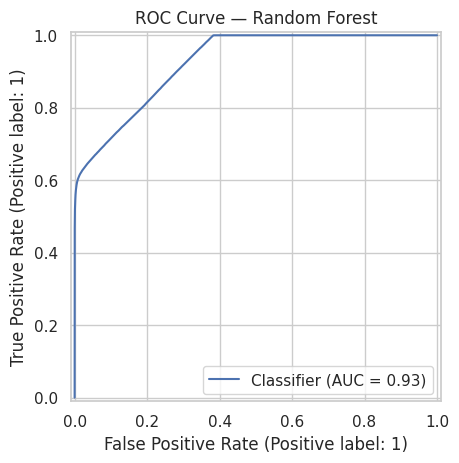

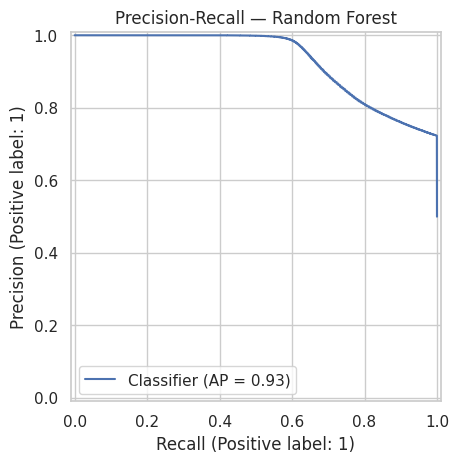

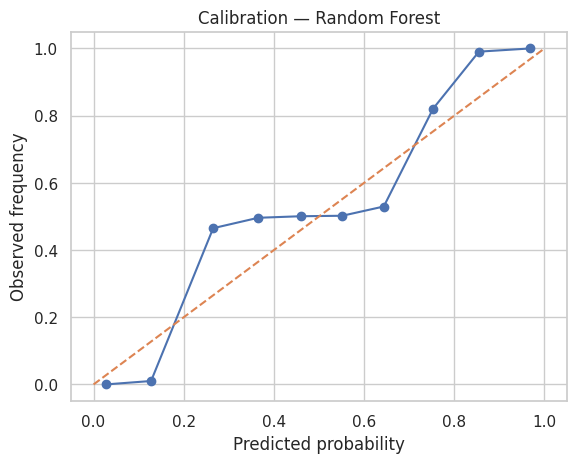


AUC comparison: {'LogReg_AUC': np.float64(0.6432), 'RF_AUC': np.float64(0.9255)}


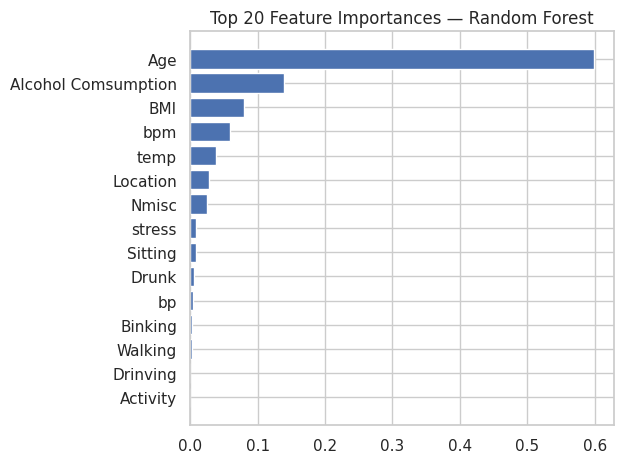

In [6]:
# =====================================================
# MODELS — Logistic Regression & Random Forest (Train/Test only)
# =====================================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.calibration import calibration_curve

RANDOM_STATE = 42

def evaluate_classifier(name, clf, X_tr, y_tr, X_te, y_te):
    clf.fit(X_tr, y_tr)

    # Probabilities & predictions
    proba = clf.predict_proba(X_te)[:, 1]
    preds = (proba >= 0.5).astype(int)

    # Metrics
    auc = roc_auc_score(y_te, proba)
    print(f"\n=== {name} — Test Set ===")
    print("ROC-AUC:", round(auc, 4))
    print("Confusion Matrix:\n", confusion_matrix(y_te, preds))
    print(classification_report(y_te, preds, digits=4))

    # Curves
    RocCurveDisplay.from_predictions(y_te, proba)
    plt.title(f'ROC Curve — {name}')
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_te, proba)
    plt.title(f'Precision-Recall — {name}')
    plt.show()

    # Simple calibration curve (version-safe)
    prob_true, prob_pred = calibration_curve(y_te, proba, n_bins=10, strategy='uniform')
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('Predicted probability')
    plt.ylabel('Observed frequency')
    plt.title(f'Calibration — {name}')
    plt.show()

    return auc, proba, preds, clf


# ----------------- 1) Logistic Regression -----------------
log_reg = LogisticRegression(
    max_iter=2000,
    solver='saga',
    random_state=RANDOM_STATE
)
auc_lr, proba_lr, preds_lr, clf_lr = evaluate_classifier(
    "Logistic Regression", log_reg, X_train_prepared, y_train, X_test_prepared, y_test
)


# ----------------- 2) Random Forest -----------------
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
auc_rf, proba_rf, preds_rf, clf_rf = evaluate_classifier(
    "Random Forest", rf, X_train_prepared, y_train, X_test_prepared, y_test
)

print("\nAUC comparison:", {"LogReg_AUC": round(auc_lr, 4), "RF_AUC": round(auc_rf, 4)})


# =====================================================
# FEATURE IMPORTANCE (Random Forest) with proper names
# =====================================================
# Build feature names from the fitted preprocessor

num_names = preprocess.named_transformers_['num'].get_feature_names_out(num_cols) \
            if hasattr(preprocess.named_transformers_['num'], 'get_feature_names_out') else np.array(num_cols)

ohe = preprocess.named_transformers_['cat'].named_steps['encoder'] if 'cat' in preprocess.named_transformers_ else None
if ohe is not None and len(cat_cols) > 0:
    cat_names = ohe.get_feature_names_out(cat_cols)
    feature_names = np.concatenate([num_names, cat_names])
else:
    feature_names = np.array(num_names)

# Show top 20 importances
if hasattr(clf_rf, "feature_importances_"):
    importances = clf_rf.feature_importances_
    order = np.argsort(importances)[::-1][:20]
    plt.barh(feature_names[order][::-1], importances[order][::-1])
    plt.title("Top 20 Feature Importances — Random Forest")
    plt.tight_layout()
    plt.show()
else:
    print("Feature importances not available for this model.")





=== KNN (k=7) — Test Set ===
ROC-AUC: 0.6902
Confusion Matrix:
 [[60989 39125]
 [32110 67776]]
              precision    recall  f1-score   support

           0     0.6551    0.6092    0.6313    100114
           1     0.6340    0.6785    0.6555     99886

    accuracy                         0.6438    200000
   macro avg     0.6446    0.6439    0.6434    200000
weighted avg     0.6446    0.6438    0.6434    200000



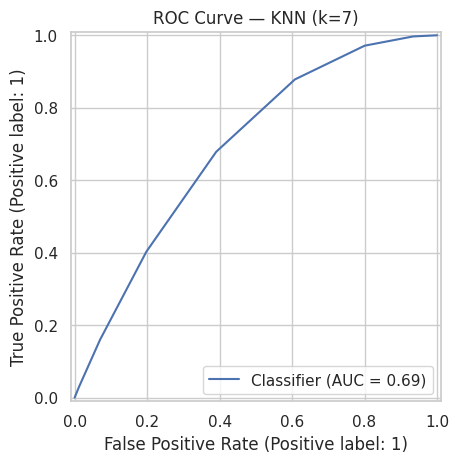

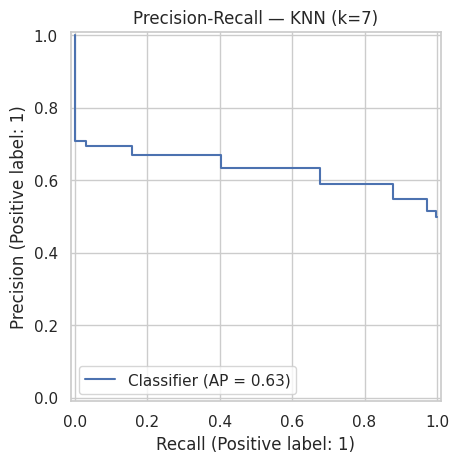

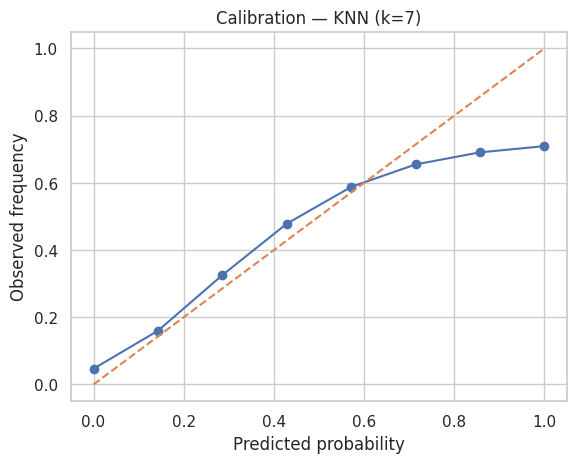


=== KNN (k=9) — Test Set ===
ROC-AUC: 0.692
Confusion Matrix:
 [[60724 39390]
 [31732 68154]]
              precision    recall  f1-score   support

           0     0.6568    0.6065    0.6307    100114
           1     0.6337    0.6823    0.6571     99886

    accuracy                         0.6444    200000
   macro avg     0.6453    0.6444    0.6439    200000
weighted avg     0.6453    0.6444    0.6439    200000



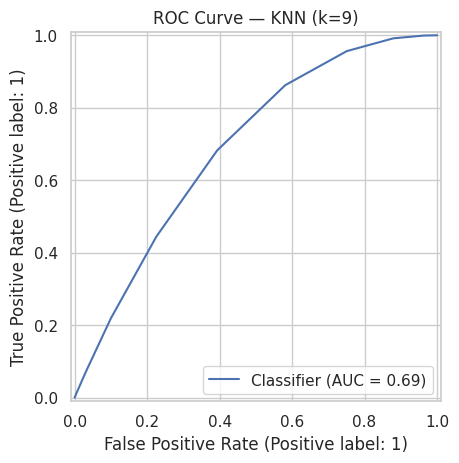

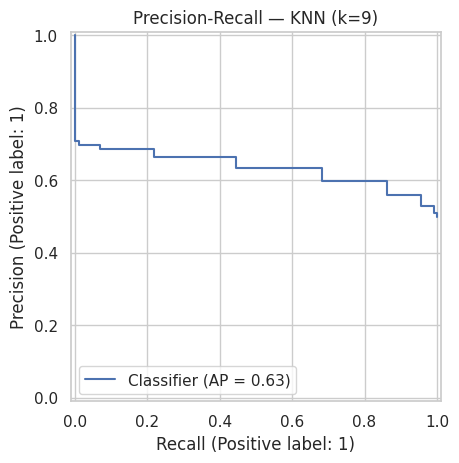

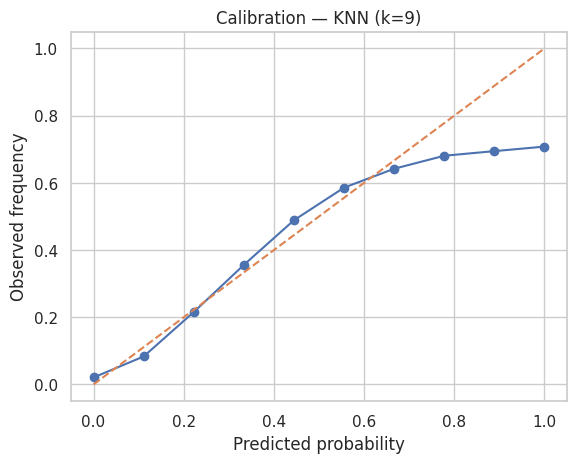

In [9]:
# =====================================================
# 3) K-Nearest Neighbors (based on Shmueli et al., Ch.7 and Lab 1.1)
# =====================================================
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Try a few neighbor values quickly
for k in [7, 9]:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    auc_knn, proba_knn, preds_knn, clf_knn = evaluate_classifier(
        f"KNN (k={k})", knn, X_train_prepared, y_train, X_test_prepared, y_test
    )




                 Model   ROC-AUC
0        Random Forest  0.925516
1  K-Nearest Neighbors  0.691965
2  Logistic Regression  0.643155


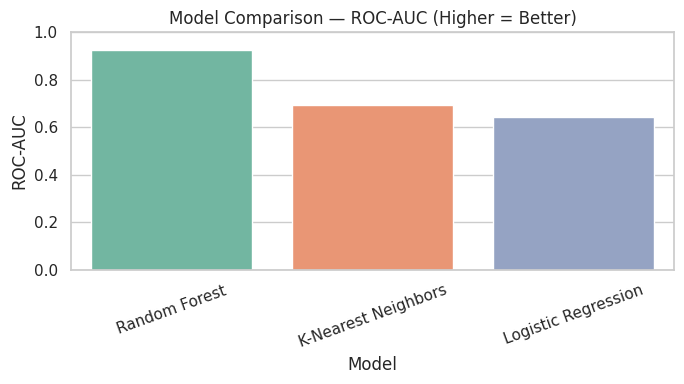

In [11]:
# =====================================================
# MODEL PERFORMANCE COMPARISON (Shmueli et al., Ch.7 style)
# =====================================================
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Collect key metrics into a summary DataFrame
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'K-Nearest Neighbors'],
    'ROC-AUC': [auc_lr, auc_rf, auc_knn]
})

# Sort by performance
results = results.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)
print(results)

# Plot (following course lab style)
plt.figure(figsize=(7,4))
sns.barplot(data=results, x='Model', y='ROC-AUC', palette='Set2')
plt.title('Model Comparison — ROC-AUC (Higher = Better)')
plt.ylim(0, 1)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


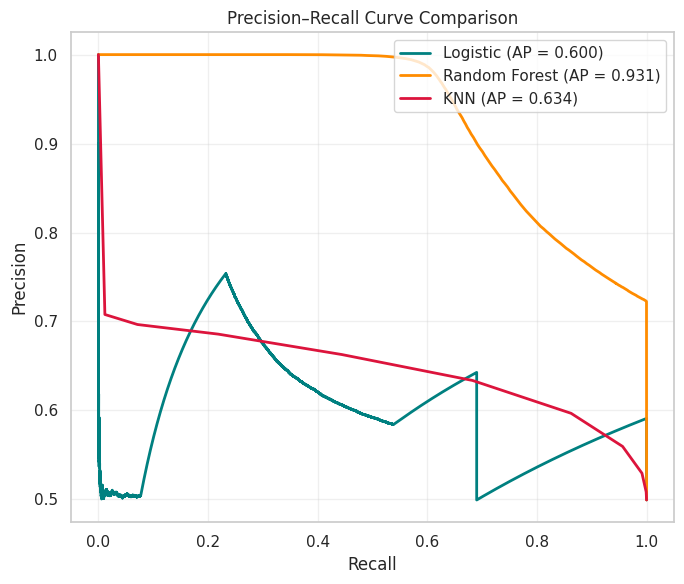

In [12]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute PR curves
p_lr, r_lr, _ = precision_recall_curve(y_test, proba_lr)
p_rf, r_rf, _ = precision_recall_curve(y_test, proba_rf)
p_knn, r_knn, _ = precision_recall_curve(y_test, proba_knn)

plt.figure(figsize=(7,6))
plt.plot(r_lr, p_lr, lw=2, color='teal', label=f'Logistic (AP = {average_precision_score(y_test, proba_lr):.3f})')
plt.plot(r_rf, p_rf, lw=2, color='darkorange', label=f'Random Forest (AP = {average_precision_score(y_test, proba_rf):.3f})')
plt.plot(r_knn, p_knn, lw=2, color='crimson', label=f'KNN (AP = {average_precision_score(y_test, proba_knn):.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve Comparison')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

